# Control Flow Graph

The code in this notebook helps with obtaining the control flow graph of python functions.

**Prerequisites**

* This notebook needs some understanding on advanced concepts in Python, notably 
    * classes

## Control Flow Graph

The class `PyCFG` allows one to obtain the control flow graph.

```Python
from ControlFlow import gen_cfg, to_graph
cfg = gen_cfg(inspect.getsource(my_function))
to_graph(cfg)
```

In [1]:
import bookutils.setup

In [2]:
from bookutils import print_content

In [3]:
import ast
import re

In [4]:
from graphviz import Source, Digraph

### Registry

In [5]:
REGISTRY_IDX = 0

In [6]:
REGISTRY = {}

In [7]:
def get_registry_idx():
    global REGISTRY_IDX
    v = REGISTRY_IDX
    REGISTRY_IDX += 1
    return v

In [8]:
def reset_registry():
    global REGISTRY_IDX
    global REGISTRY
    REGISTRY_IDX = 0
    REGISTRY = {}

In [9]:
def register_node(node):
    node.rid = get_registry_idx()
    REGISTRY[node.rid] = node

In [10]:
def get_registry():
    return dict(REGISTRY)

### CFGNode
We start with the `CFGNode` representing each node in the control flow graph.
\todo{Augmented and annotated assignments (`a += 1`), (`a:int = 1`)}.

In [11]:
class CFGNode(dict):
    def __init__(self, parents=[], ast=None):
        assert type(parents) is list
        register_node(self)
        self.parents = parents
        self.ast_node = ast
        self.update_children(parents)  # requires self.rid
        self.children = []
        self.calls = []

    def i(self):
        return str(self.rid)

    def update_children(self, parents):
        for p in parents:
            p.add_child(self)

    def add_child(self, c):
        if c not in self.children:
            self.children.append(c)

    def lineno(self):
        return self.ast_node.lineno if hasattr(self.ast_node, 'lineno') else 0

    def __str__(self):
        return "id:%d line[%d] parents: %s : %s" % (
            self.rid, self.lineno(), str([p.rid for p in self.parents]),
            self.source())

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.rid == other.rid

    def __neq__(self, other):
        return self.rid != other.rid

    def set_parents(self, p):
        self.parents = p

    def add_parent(self, p):
        if p not in self.parents:
            self.parents.append(p)

    def add_parents(self, ps):
        for p in ps:
            self.add_parent(p)

    def add_calls(self, func):
        self.calls.append(func)

    def source(self):
        return ast.unparse(self.ast_node).strip()

    def to_json(self):
        return {
            'id': self.rid,
            'parents': [p.rid for p in self.parents],
            'children': [c.rid for c in self.children],
            'calls': self.calls,
            'at': self.lineno(),
            'ast': self.source()
        }

### PyCFG

Next, the `PyCFG` class which is responsible for parsing, and holding the graph.

In [12]:
class PyCFG:
    def __init__(self):
        self.founder = CFGNode(
            parents=[], ast=ast.parse('start').body[0])  # sentinel
        self.founder.ast_node.lineno = 0
        self.functions = {}
        self.functions_node = {}

In [13]:
class PyCFG(PyCFG):
    def parse(self, src):
        return ast.parse(src)

In [14]:
class PyCFG(PyCFG):
    def walk(self, node, myparents):
        fname = "on_%s" % node.__class__.__name__.lower()
        if hasattr(self, fname):
            fn = getattr(self, fname)
            v = fn(node, myparents)
            return v
        else:
            return myparents

In [15]:
class PyCFG(PyCFG):
    def on_module(self, node, myparents):
        """
        Module(stmt* body)
        """
        # each time a statement is executed unconditionally, make a link from
        # the result to next statement
        p = myparents
        for n in node.body:
            p = self.walk(n, p)
        return p

In [16]:
class PyCFG(PyCFG):
    def on_augassign(self, node, myparents):
        """
         AugAssign(expr target, operator op, expr value)
        """
        p = [CFGNode(parents=myparents, ast=node)]
        p = self.walk(node.value, p)

        return p

In [17]:
class PyCFG(PyCFG):
    def on_annassign(self, node, myparents):
        """
        AnnAssign(expr target, expr annotation, expr? value, int simple)
        """
        p = [CFGNode(parents=myparents, ast=node)]
        p = self.walk(node.value, p)

        return p

In [18]:
class PyCFG(PyCFG):
    def on_assign(self, node, myparents):
        """
        Assign(expr* targets, expr value)
        """
        if len(node.targets) > 1:
            raise NotImplemented('Parallel assignments')

        p = [CFGNode(parents=myparents, ast=node)]
        p = self.walk(node.value, p)

        return p

In [19]:
class PyCFG(PyCFG):
    def on_pass(self, node, myparents):
        return [CFGNode(parents=myparents, ast=node)]

In [20]:
class PyCFG(PyCFG):
    def on_break(self, node, myparents):
        parent = myparents[0]
        while not hasattr(parent, 'exit_nodes'):
            # we have ordered parents
            parent = parent.parents[0]

        assert hasattr(parent, 'exit_nodes')
        p = CFGNode(parents=myparents, ast=node)

        # make the break one of the parents of label node.
        parent.exit_nodes.append(p)

        # break doesn't have immediate children
        return []

In [21]:
class PyCFG(PyCFG):
    def on_continue(self, node, myparents):
        parent = myparents[0]
        while not hasattr(parent, 'exit_nodes'):
            # we have ordered parents
            parent = parent.parents[0]
        assert hasattr(parent, 'exit_nodes')
        p = CFGNode(parents=myparents, ast=node)

        # make continue one of the parents of the original test node.
        parent.add_parent(p)

        # return the parent because a continue is not the parent
        # for the just next node
        return []

In [22]:
class PyCFG(PyCFG):
    def on_for(self, node, myparents):
        # node.target in node.iter: node.body
        # The For loop in python (no else) can be translated
        # as follows:
        # 
        # for a in iterator:
        #      mystatements
        #
        # __iv = iter(iterator)
        # while __iv.__length_hint() > 0:
        #     a = next(__iv)
        #     mystatements

        init_node = CFGNode(parents=myparents,
            ast=ast.parse('__iv = iter(%s)' % ast.unparse(node.iter).strip()).body[0])
        ast.copy_location(init_node.ast_node, node.iter)

        _test_node = CFGNode(
            parents=[init_node],
            ast=ast.parse('_for: __iv.__length__hint__() > 0').body[0])
        ast.copy_location(_test_node.ast_node, node)

        # we attach the label node here so that break can find it.
        _test_node.exit_nodes = []
        test_node = self.walk(node.iter, [_test_node])

        extract_node = CFGNode(parents=test_node,
            ast=ast.parse('%s = next(__iv)' % ast.unparse(node.target).strip()).body[0])
        ast.copy_location(extract_node.ast_node, node.iter)

        # now we evaluate the body, one at a time.
        p1 = [extract_node]
        for n in node.body:
            p1 = self.walk(n, p1)

        # the test node is looped back at the end of processing.
        _test_node.add_parents(p1)

        return _test_node.exit_nodes + test_node

In [23]:
class PyCFG(PyCFG):
    def on_while(self, node, myparents):
        # For a while, the earliest parent is the node.test
        _test_node = CFGNode(
            parents=myparents,
            ast=ast.parse(
                '_while: %s' % ast.unparse(node.test).strip()).body[0])
        ast.copy_location(_test_node.ast_node, node.test)
        _test_node.exit_nodes = []
        test_node = self.walk(node.test, [_test_node])

        # we attach the label node here so that break can find it.

        # now we evaluate the body, one at a time.
        assert len(test_node) == 1
        p1 = test_node
        for n in node.body:
            p1 = self.walk(n, p1)

        # the test node is looped back at the end of processing.
        _test_node.add_parents(p1)

        # link label node back to the condition.
        return _test_node.exit_nodes + test_node

In [24]:
class PyCFG(PyCFG):
    def on_if(self, node, myparents):
        _test_node = CFGNode(
            parents=myparents,
            ast=ast.parse(
                '_if: %s' % ast.unparse(node.test).strip()).body[0])
        ast.copy_location(_test_node.ast_node, node.test)
        test_node = self.walk(node.test, [ _test_node])
        assert len(test_node) == 1
        g1 = test_node
        for n in node.body:
            g1 = self.walk(n, g1)
        g2 = test_node
        for n in node.orelse:
            g2 = self.walk(n, g2)
        return g1 + g2

In [25]:
class PyCFG(PyCFG):
    def on_binop(self, node, myparents):
        left = self.walk(node.left, myparents)
        right = self.walk(node.right, left)
        return right

In [26]:
class PyCFG(PyCFG):
    def on_compare(self, node, myparents):
        left = self.walk(node.left, myparents)
        right = self.walk(node.comparators[0], left)
        return right

In [27]:
class PyCFG(PyCFG):
    def on_unaryop(self, node, myparents):
        return self.walk(node.operand, myparents)

In [28]:
class PyCFG(PyCFG):
    def on_call(self, node, myparents):
        def get_func(node):
            if type(node.func) is ast.Name:
                mid = node.func.id
            elif type(node.func) is ast.Attribute:
                mid = node.func.attr
            elif type(node.func) is ast.Call:
                mid = get_func(node.func)
            else:
                raise Exception(str(type(node.func)))
            return mid
            #mid = node.func.value.id

        p = myparents
        for a in node.args:
            p = self.walk(a, p)
        mid = get_func(node)
        myparents[0].add_calls(mid)

        # these need to be unlinked later if our module actually defines these
        # functions. Otherwsise we may leave them around.
        # during a call, the direct child is not the next
        # statement in text.
        for c in p:
            c.calllink = 0
        return p

In [29]:
class PyCFG(PyCFG):
    def on_expr(self, node, myparents):
        p = [CFGNode(parents=myparents, ast=node)]
        return self.walk(node.value, p)

In [30]:
class PyCFG(PyCFG):
    def on_return(self, node, myparents):
        if type(myparents) is tuple:
            parent = myparents[0][0]
        else:
            parent = myparents[0]

        val_node = self.walk(node.value, myparents)
        # on return look back to the function definition.
        while not hasattr(parent, 'return_nodes'):
            parent = parent.parents[0]
        assert hasattr(parent, 'return_nodes')

        p = CFGNode(parents=val_node, ast=node)

        # make the break one of the parents of label node.
        parent.return_nodes.append(p)

        # return doesnt have immediate children
        return []

In [31]:
class PyCFG(PyCFG):
    def on_functiondef(self, node, myparents):
        # a function definition does not actually continue the thread of
        # control flow
        # name, args, body, decorator_list, returns
        fname = node.name
        args = node.args
        returns = node.returns

        enter_node = CFGNode(
            parents=[],
            ast=ast.parse('enter: %s(%s)' % (node.name, ', '.join(
                [a.arg for a in node.args.args]))).body[0])  # sentinel
        enter_node.calleelink = True
        ast.copy_location(enter_node.ast_node, node)
        exit_node = CFGNode(
            parents=[],
            ast=ast.parse('exit: %s(%s)' % (node.name, ', '.join(
                [a.arg for a in node.args.args]))).body[0])  # sentinel
        exit_node.fn_exit_node = True
        ast.copy_location(exit_node.ast_node, node)
        enter_node.return_nodes = []  # sentinel

        p = [enter_node]
        for n in node.body:
            p = self.walk(n, p)

        for n in p:
            if n not in enter_node.return_nodes:
                enter_node.return_nodes.append(n)

        for n in enter_node.return_nodes:
            exit_node.add_parent(n)

        self.functions[fname] = [enter_node, exit_node]
        self.functions_node[enter_node.lineno()] = fname

        return myparents

In [32]:
class PyCFG(PyCFG):
    def get_defining_function(self, node):
        if node.lineno() in self.functions_node:
            return self.functions_node[node.lineno()]
        if not node.parents:
            self.functions_node[node.lineno()] = ''
            return ''
        val = self.get_defining_function(node.parents[0])
        self.functions_node[node.lineno()] = val
        return val

In [33]:
class PyCFG(PyCFG):
    def link_functions(self):
        for nid, node in REGISTRY.items():
            if node.calls:
                for calls in node.calls:
                    if calls in self.functions:
                        enter, exit = self.functions[calls]
                        enter.add_parent(node)
                        if node.children:
                            # # until we link the functions up, the node
                            # # should only have succeeding node in text as
                            # # children.
                            # assert(len(node.children) == 1)
                            # passn = node.children[0]
                            # # We require a single pass statement after every
                            # # call (which means no complex expressions)
                            # assert(type(passn.ast_node) == ast.Pass)

                            # # unlink the call statement
                            assert node.calllink > -1
                            node.calllink += 1
                            for i in node.children:
                                i.add_parent(exit)
                            # passn.set_parents([exit])
                            # ast.copy_location(exit.ast_node, passn.ast_node)

                            # #for c in passn.children: c.add_parent(exit)
                            # #passn.ast_node = exit.ast_node

In [34]:
class PyCFG(PyCFG):
    def update_functions(self):
        for nid, node in REGISTRY.items():
            _n = self.get_defining_function(node)

In [35]:
class PyCFG(PyCFG):
    def update_children(self):
        for nid, node in REGISTRY.items():
            for p in node.parents:
                p.add_child(node)

In [36]:
class PyCFG(PyCFG):
    def gen_cfg(self, src):
        """
        >>> i = PyCFG()
        >>> i.walk("100")
        5
        """
        node = self.parse(src)
        nodes = self.walk(node, [self.founder])
        self.last_node = CFGNode(parents=nodes, ast=ast.parse('stop').body[0])
        ast.copy_location(self.last_node.ast_node, self.founder.ast_node)
        self.update_children()
        self.update_functions()
        self.link_functions()

### Supporting Functions

In [37]:
def compute_dominator(cfg, start=0, key='parents'):
    dominator = {}
    dominator[start] = {start}
    all_nodes = set(cfg.keys())
    rem_nodes = all_nodes - {start}
    for n in rem_nodes:
        dominator[n] = all_nodes

    c = True
    while c:
        c = False
        for n in rem_nodes:
            pred_n = cfg[n][key]
            doms = [dominator[p] for p in pred_n]
            i = set.intersection(*doms) if doms else set()
            v = {n} | i
            if dominator[n] != v:
                c = True
            dominator[n] = v
    return dominator

In [38]:
def compute_flow(pythonfile):
    cfg, first, last = get_cfg(pythonfile)
    return cfg, compute_dominator(
        cfg, start=first), compute_dominator(
            cfg, start=last, key='children')

In [39]:
def gen_cfg(fnsrc, remove_start_stop=True):
    reset_registry()
    cfg = PyCFG()
    cfg.gen_cfg(fnsrc)
    cache = dict(REGISTRY)
    if remove_start_stop:
        return {
            k: cache[k]
            for k in cache if cache[k].source() not in {'start', 'stop'}
        }
    else:
        return cache

In [40]:
def get_cfg(src):
    reset_registry()
    cfg = PyCFG()
    cfg.gen_cfg(src)
    cache = dict(REGISTRY)
    g = {}
    for k, v in cache.items():
        j = v.to_json()
        at = j['at']
        parents_at = [cache[p].to_json()['at'] for p in j['parents']]
        children_at = [cache[c].to_json()['at'] for c in j['children']]
        if at not in g:
            g[at] = {'parents': set(), 'children': set()}
        # remove dummy nodes
        ps = set([p for p in parents_at if p != at])
        cs = set([c for c in children_at if c != at])
        g[at]['parents'] |= ps
        g[at]['children'] |= cs
        if v.calls:
            g[at]['calls'] = v.calls
        g[at]['function'] = cfg.functions_node[v.lineno()]
    return (g, cfg.founder.ast_node.lineno, cfg.last_node.ast_node.lineno)

In [41]:
def to_graph(cache, arcs=[]):
    graph = Digraph(comment='Control Flow Graph')
    colors = {0: 'blue', 1: 'red'}
    kind = {0: 'T', 1: 'F'}
    cov_lines = set(i for i, j in arcs)
    for nid, cnode in cache.items():
        lineno = cnode.lineno()
        shape, peripheries = 'oval', '1'
        if isinstance(cnode.ast_node, ast.AnnAssign):
            if cnode.ast_node.target.id in {'_if', '_for', '_while'}:
                shape = 'diamond'
            elif cnode.ast_node.target.id in {'enter', 'exit'}:
                shape, peripheries = 'oval', '2'
        else:
            shape = 'rectangle'
        graph.node(cnode.i(), "%d: %s" % (lineno, unhack(cnode.source())),
                   shape=shape, peripheries=peripheries)
        for pn in cnode.parents:
            plineno = pn.lineno()
            if hasattr(pn, 'calllink') and pn.calllink > 0 and not hasattr(
                    cnode, 'calleelink'):
                graph.edge(pn.i(), cnode.i(), style='dotted', weight=100)
                continue

            if arcs:
                if (plineno, lineno) in arcs:
                    graph.edge(pn.i(), cnode.i(), color='green')
                elif plineno == lineno and lineno in cov_lines:
                    graph.edge(pn.i(), cnode.i(), color='green')
                # child is exit and parent is covered
                elif hasattr(cnode, 'fn_exit_node') and plineno in cov_lines:
                    graph.edge(pn.i(), cnode.i(), color='green')
                # parent is exit and one of its parents is covered.
                elif hasattr(pn, 'fn_exit_node') and len(
                        set(n.lineno() for n in pn.parents) | cov_lines) > 0:
                    graph.edge(pn.i(), cnode.i(), color='green')
                # child is a callee (has calleelink) and one of the parents is covered.
                elif plineno in cov_lines and hasattr(cnode, 'calleelink'):
                    graph.edge(pn.i(), cnode.i(), color='green')
                else:
                    graph.edge(pn.i(), cnode.i(), color='red')
            else:
                order = {c.i(): i for i, c in enumerate(pn.children)}
                if len(order) < 2:
                    graph.edge(pn.i(), cnode.i())
                else:
                    o = order[cnode.i()]
                    graph.edge(pn.i(), cnode.i(), color=colors[o], label=kind[o])
    return graph

In [42]:
def unhack(v):
    for i in ['if', 'while', 'for', 'elif']:
        v = re.sub(r'^_%s:' % i, '%s:' % i, v)
    return v

### Examples

#### check_triangle

In [43]:
def check_triangle(a, b, c):
    if a == b:
        if a == c:
            if b == c:
                return "Equilateral"
            else:
                return "Isosceles"
        else:
            return "Isosceles"
    else:
        if b != c:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"
        else:
            return "Isosceles"

In [44]:
import inspect

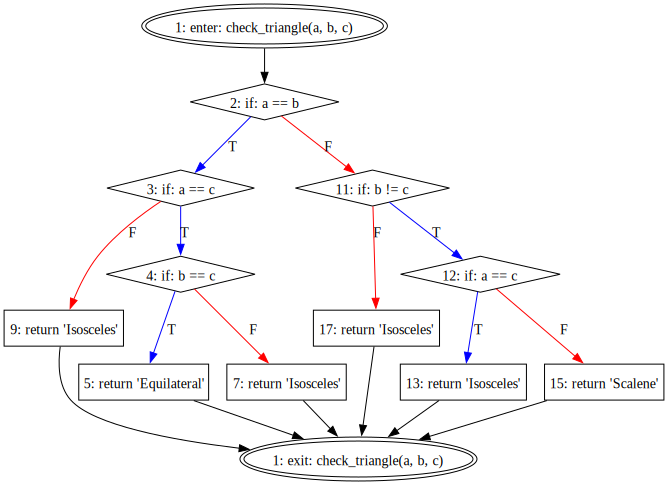

In [45]:
to_graph(gen_cfg(inspect.getsource(check_triangle)))

#### cgi_decode

Note that we do not yet support _augmented assignments_: i.e assignments such as `+=`

In [46]:
def cgi_decode(s):
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

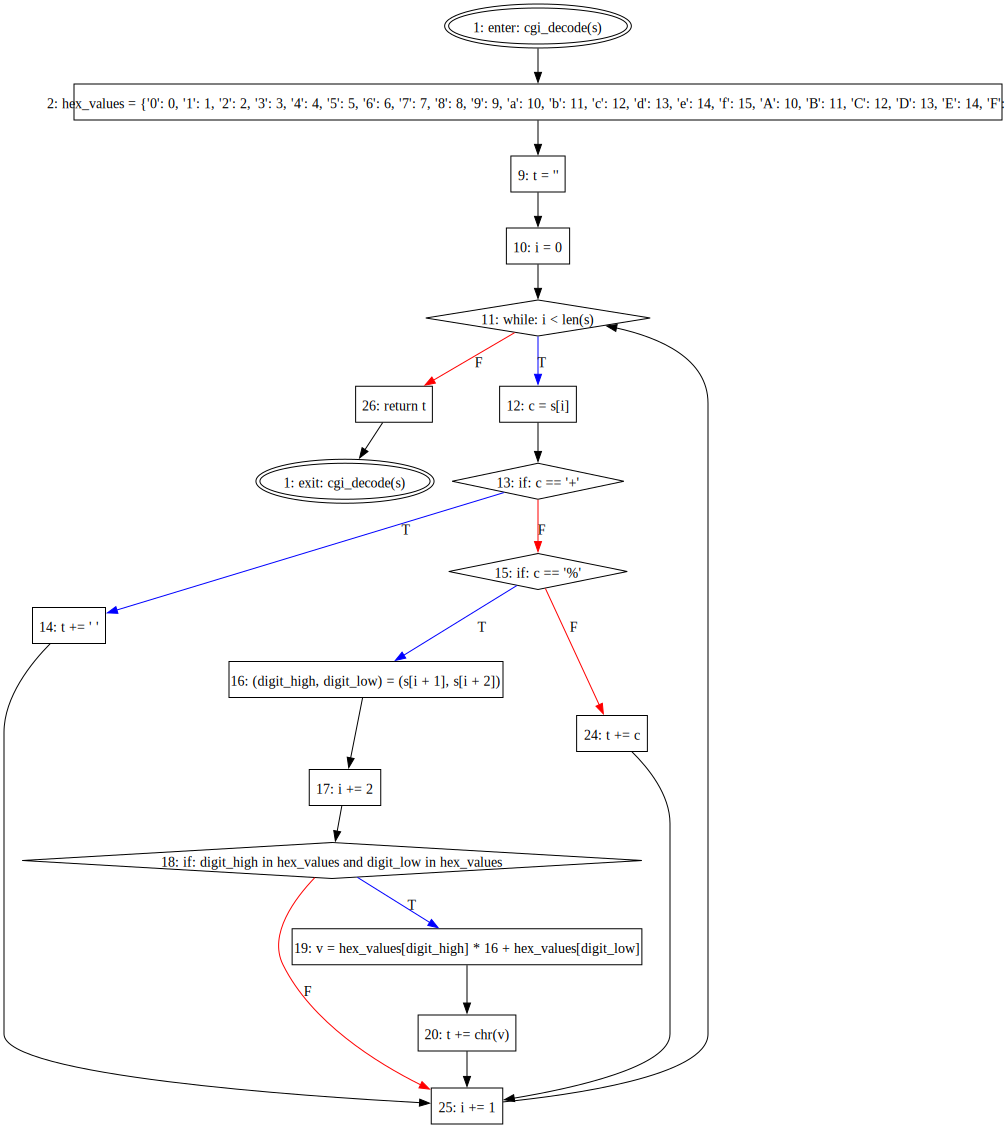

In [47]:
to_graph(gen_cfg(inspect.getsource(cgi_decode)))

#### gcd

In [48]:
def gcd(a, b):
    if a<b:
        c: int = a
        a: int = b
        b: int = c

    while b != 0 :
        c: int = a
        a: int = b
        b: int = c % b
    return a

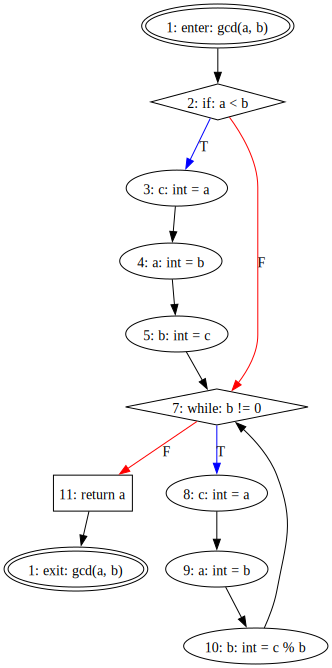

In [49]:
to_graph(gen_cfg(inspect.getsource(gcd)))

In [50]:
def compute_gcd(x, y):
    if x > y:
        small = y
    else:
        small = x
    for i in range(1, small+1):
        if((x % i == 0) and (y % i == 0)):
            gcd = i

    return gcd

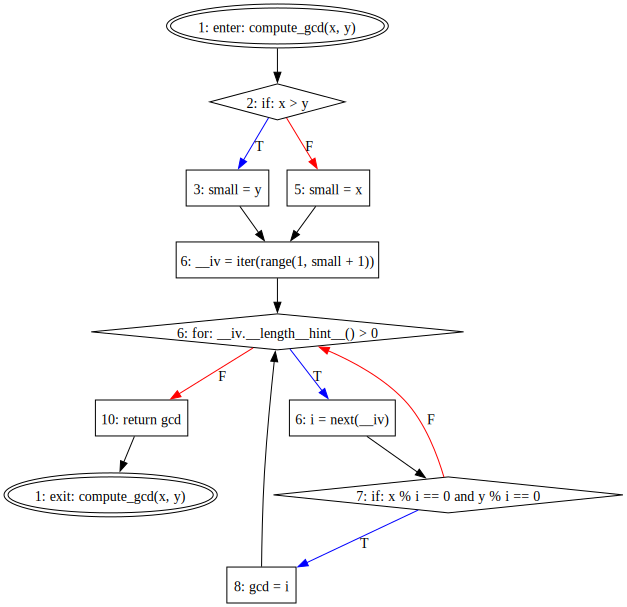

In [51]:
to_graph(gen_cfg(inspect.getsource(compute_gcd)))

#### fib

Note that the *for-loop* requires additional massaging. While we show the labels correctly, the *comparison node* needs to be extracted. Hence, the representation is not accurate.

In [52]:
def fib(n,):
    ls = [0, 1]
    for i in range(n-2):
        ls.append(ls[-1] + ls[-2])
    return ls

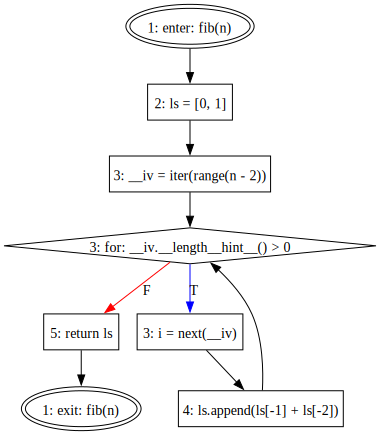

In [53]:
to_graph(gen_cfg(inspect.getsource(fib)))

#### quad_solver

In [54]:
def quad_solver(a, b, c):
    discriminant = b^2 - 4*a*c
    r1, r2 = 0, 0
    i1, i2 = 0, 0
    if discriminant >= 0:
        droot = math.sqrt(discriminant)
        r1 = (-b + droot) / (2*a)
        r2 = (-b - droot) / (2*a)
    else:
        droot = math.sqrt(-1 * discriminant)
        droot_ = droot/(2*a)
        r1, i1 = -b/(2*a), droot_
        r2, i2 = -b/(2*a), -droot_
    if i1 == 0 and i2 == 0:
        return (r1, r2)
    return ((r1,i1), (r2,i2))

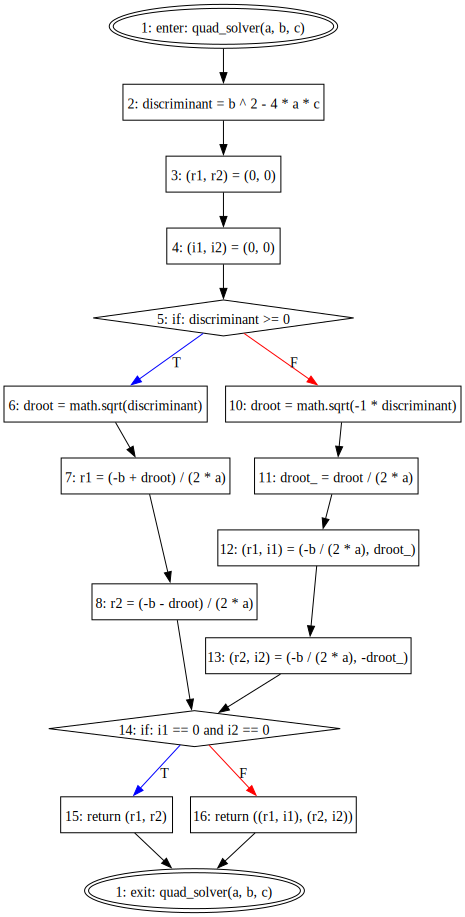

In [55]:
to_graph(gen_cfg(inspect.getsource(quad_solver)))

## Call Graph
### Install: Pyan Static Call Graph Lifter

In [56]:
import os

In [57]:
import networkx as nx  # type: ignore

### Call Graph Helpers

In [58]:
import shutil

In [59]:
PYAN = 'pyan3' if shutil.which('pyan3') is not None else 'pyan'

if shutil.which(PYAN) is None:
    # If installed from pypi, pyan may still be missing
    os.system('pip install "git+https://github.com/uds-se/pyan#egg=pyan"')
    PYAN = 'pyan3' if shutil.which('pyan3') is not None else 'pyan'

assert shutil.which(PYAN) is not None

In [60]:
def construct_callgraph(code, name="callgraph"):
    file_name = name + ".py"
    with open(file_name, 'w') as f:
        f.write(code)
    cg_file = name + '.dot'
    os.system(f'{PYAN} {file_name} --uses --defines --colored --grouped --annotated --dot > {cg_file}')

In [61]:
def callgraph(code, name="callgraph"):
    if not os.path.isfile(name + '.dot'):
        construct_callgraph(code, name)
    return Source.from_file(name + '.dot')

In [62]:
def get_callgraph(code, name="callgraph"):
    if not os.path.isfile(name + '.dot'):
        construct_callgraph(code, name)

    # This is deprecated:
    # return nx.drawing.nx_pydot.read_dot(name + '.dot')
    
    return nx.nx_agraph.read_dot(name + '.dot')

### Example: Maze

To provide a meaningful example where you can easily change the code complexity and target location, we generate the maze source code from the maze provided as string. This example is loosely based on an old [blog post](https://feliam.wordpress.com/2010/10/07/the-symbolic-maze/) on symbolic execution by Felipe Andres Manzano (Quick shout-out!).

You simply specify the maze as a string. Like so.

In [63]:
maze_string = """
+-+-----+
|X|     |
| | --+ |
| |   | |
| +-- | |
|     |#|
+-----+-+
"""

Each character in `maze_string` represents a tile. For each tile, a tile-function is generated. 
* If the current tile is "benign" (` `), the tile-function corresponding to the next input character (D, U, L, R) is called. Unexpected input characters are ignored. If no more input characters are left, it returns "VALID" and the current maze state.
* If the current tile is a "trap" (`+`,`|`,`-`), it returns "INVALID" and the current maze state.
* If the current tile is the "target" (`#`), it returns "SOLVED" and the current maze state.

The code is generated using the function `generate_maze_code`. 

In [64]:
# ignore
def maze(s: str) -> str:
    return ""  # Will be overwritten by exec()

In [65]:
# ignore
def target_tile() -> str:
    return ' '  # Will be overwritten by exec()

In [66]:
def generate_print_maze(maze_string):
    return """
def print_maze(out, row, col):
    output  = out +"\\n"
    c_row = 0
    c_col = 0
    for c in list(\"\"\"%s\"\"\"):
        if c == '\\n':
            c_row += 1
            c_col = 0
            output += "\\n"
        else:
            if c_row == row and c_col == col: output += "X"
            elif c == "X": output += " "
            else: output += c
            c_col += 1
    return output
""" % maze_string

In [67]:
def generate_trap_tile(row, col):
    return """
def tile_%d_%d(input, index):
    try: HTMLParser().feed(input)
    except: pass
    return print_maze("INVALID", %d, %d)
""" % (row, col, row, col)

In [68]:
def generate_good_tile(c, row, col):
    code = """
def tile_%d_%d(input, index):
    if (index == len(input)): return print_maze("VALID", %d, %d)
    elif input[index] == 'L': return tile_%d_%d(input, index + 1)
    elif input[index] == 'R': return tile_%d_%d(input, index + 1)
    elif input[index] == 'U': return tile_%d_%d(input, index + 1)
    elif input[index] == 'D': return tile_%d_%d(input, index + 1)
    else : return tile_%d_%d(input, index + 1)
""" % (row, col, row, col,
       row, col - 1, 
       row, col + 1, 
       row - 1, col, 
       row + 1, col,
       row, col)

    if c == "X":
        code += """
def maze(input):
    return tile_%d_%d(list(input), 0)
""" % (row, col)

    return code

In [69]:
def generate_target_tile(row, col):
    return """
def tile_%d_%d(input, index):
    return print_maze("SOLVED", %d, %d)

def target_tile():
    return "tile_%d_%d"
""" % (row, col, row, col, row, col)

In [70]:
def generate_maze_code(maze, name="maze"):
    row = 0
    col = 0
    code = generate_print_maze(maze)

    for c in list(maze):
        if c == '\n':
            row += 1
            col = 0
        else:
            if c == "-" or c == "+" or c == "|":
                code += generate_trap_tile(row, col)
            elif c == " " or c == "X":
                code += generate_good_tile(c, row, col)
            elif c == "#":
                code += generate_target_tile(row, col)
            else:
                print("Invalid maze! Try another one.")
            col += 1

    return code

Now you can generate the maze code for an arbitrary maze.

In [71]:
maze_code = generate_maze_code(maze_string)

In [72]:
print_content(maze_code, filename='.py')

def print_maze(out, row, col):
    output  = out +"\n"
    c_row = 0
    c_col = 0
    for c in list("""
+-+-----+
|X|     |
| | --+ |
| |   | |
| +-- | |
|     |#|
+-----+-+
"""):
        if c == '\n':
            c_row += 1
            c_col = 0
            output += "\n"
        else:
            if c_row == row and c_col == col: output += "X"
            elif c == "X": output += " "
            else: output += c
            c_col += 1
    return output

def tile_1_0(input, index):
    try: HTMLParser().feed(input)
    except: pass
    return print_maze("INVALID", 1, 0)

def tile_1_1(input, index):
    try: HTMLParser().feed(input)
    except: pass
    return print_maze("INVALID", 1, 1)

def tile_1_2(input, index):
    try: HTMLParser().feed(input)
    except: pass
    return print_maze("INVALID", 1, 2)

def tile_1_3(input, index):
    try: HTMLParser().feed(input)
    except: pass
    return print_maze("INVALID", 1, 3)

def tile_1_4(input, index):
    try: HTMLParser().feed(input)


In [73]:
exec(maze_code)

In [74]:
# Appending one more 'D', you have reached the target.
print(maze("DDDDRRRRUULLUURRRRDDD"))

VALID

+-+-----+
| |     |
| | --+ |
| |   | |
| +-- |X|
|     |#|
+-----+-+



This is the corresponding call graph.

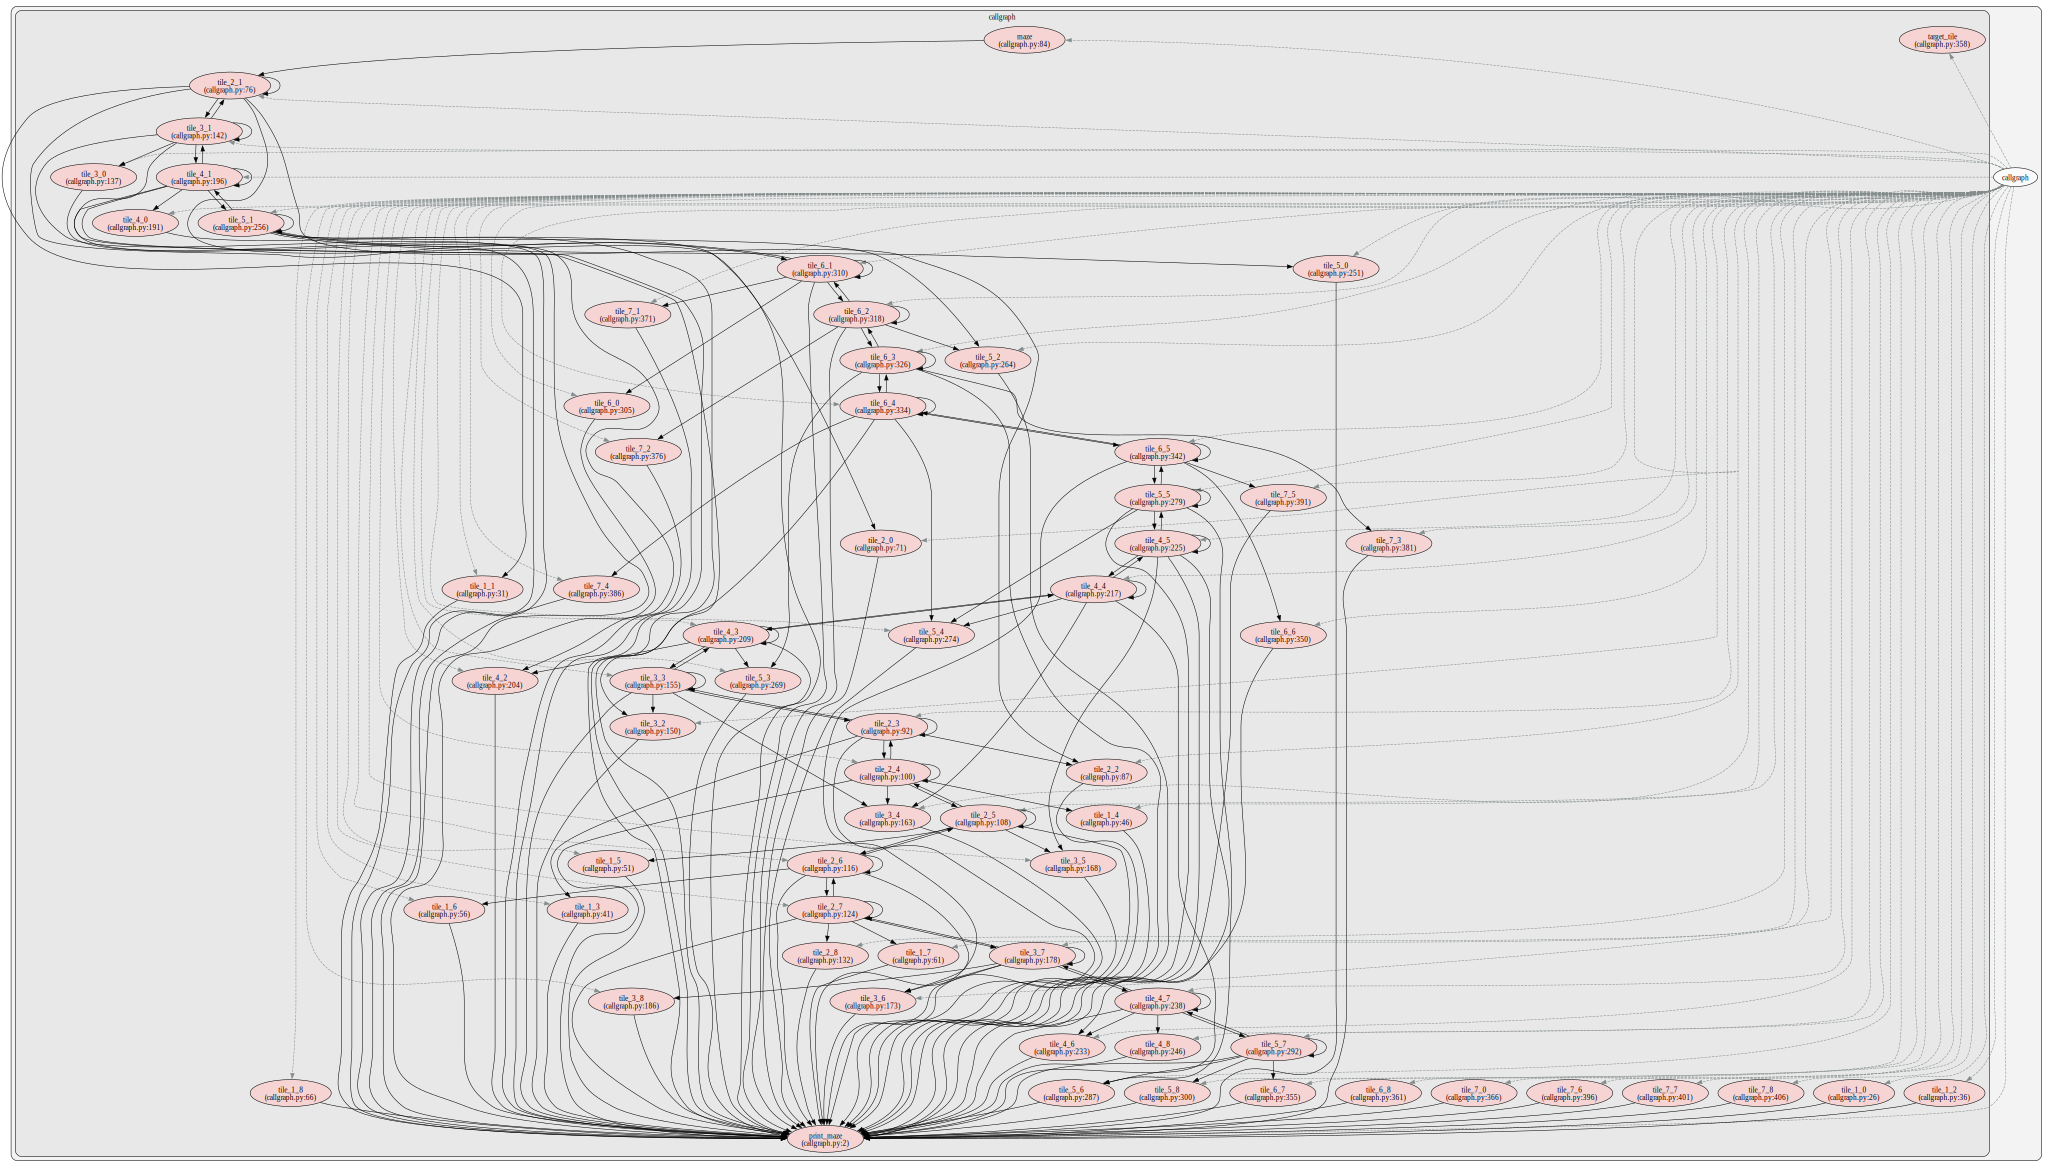

In [75]:
callgraph(maze_code)

## Cleanup

We're done, so we clean up:

In [76]:
if os.path.exists('callgraph.dot'):
    os.remove('callgraph.dot')

if os.path.exists('callgraph.py'):
    os.remove('callgraph.py')